In [1]:
import pandas as pd
import requests
import json
import config
from matplotlib import style
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [23]:
Dependent_Variable = 'AIG'
Independent_Variable = 'MET'

In [24]:
class core_stock():
    def daily(symbol, function = 'TIME_SERIES_DAILY', outputsize='full', api_key = config.api_key):
        url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={outputsize}&apikey={api_key}'
        r = requests.get(url)
        data = r.json()
        return data
 
IV = core_stock.daily(Independent_Variable)
DV = core_stock.daily(Dependent_Variable)

IV = pd.DataFrame.from_dict(IV['Time Series (Daily)'], orient='index')
IV[f'{Independent_Variable}_close'] = IV['4. close'].astype('float')
IV = IV.drop(['1. open', '2. high', '3. low', '4. close', '5. volume'], axis=1)

DV = pd.DataFrame.from_dict(DV['Time Series (Daily)'], orient='index')
DV[f'{Dependent_Variable}_close'] = DV['4. close'].astype('float')
DV = DV.drop(['1. open', '2. high', '3. low', '4. close', '5. volume'], axis=1)

df = pd.concat([IV,DV],join='inner', axis=1)
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['index'])
df = df[df['Date'].dt.year > 2021]

In [25]:
import statsmodels.formula.api as smf
model = smf.ols(data=df,formula=f'{Dependent_Variable}_close ~ {Independent_Variable}_close').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              AIG_close   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     610.6
Date:                Thu, 25 Aug 2022   Prob (F-statistic):           1.16e-56
Time:                        22:46:41   Log-Likelihood:                -338.53
No. Observations:                 163   AIC:                             681.1
Df Residuals:                     161   BIC:                             687.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.0874      3.106     -6.144      0.0

In [26]:
from sklearn import linear_model
from sklearn import metrics

x = np.c_[df[f'{Independent_Variable}_close']]
y = np.c_[df[f'{Dependent_Variable}_close']]
model = linear_model.LinearRegression().fit(x,y)

print("R squared = ",model.score(x,y))
print("Intercept = ",model.intercept_[0])
print("Coefficient = ",model.coef_[0][0])

print("Mean Absolute Error = ",metrics.mean_absolute_error(x,y))
print("Mean Squared Error = ",metrics.mean_squared_error(x,y))


R squared =  0.7913379294592172
Intercept =  -19.0873592162354
Coefficient =  1.1604005746133141
Mean Absolute Error =  8.489693251533744
Mean Squared Error =  76.0730883435583


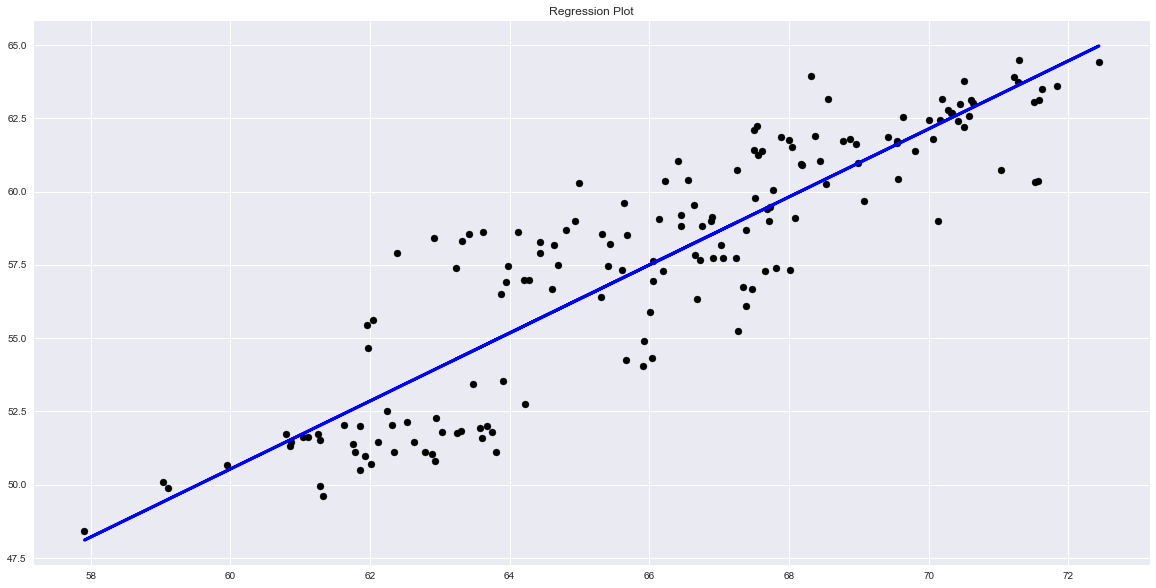

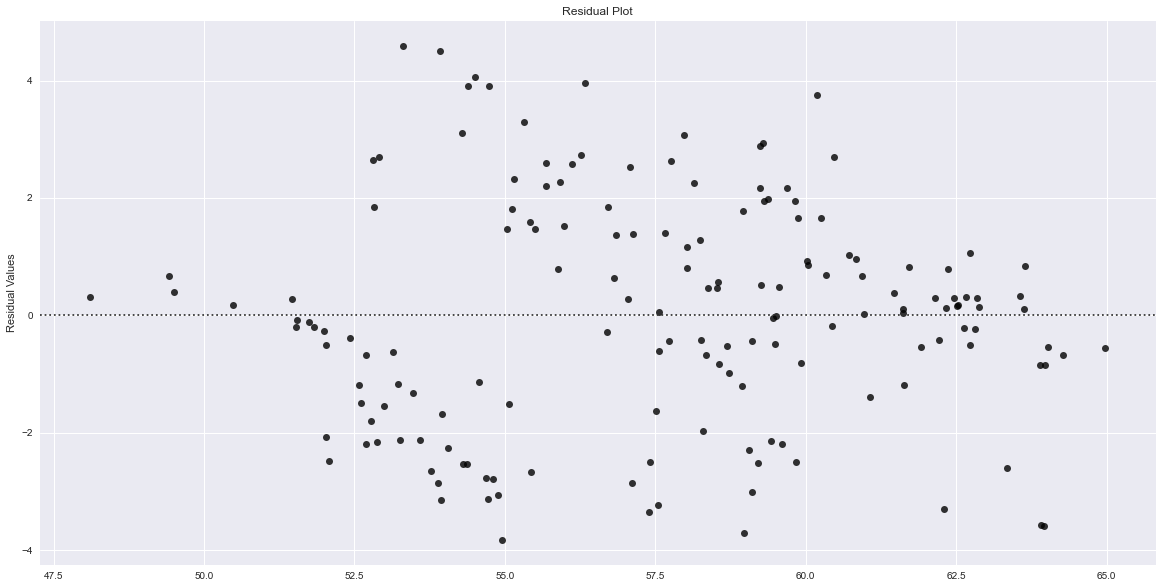

In [27]:
prediction = model.predict(x)
residual = (y - prediction)

style.use('seaborn')
plt.figure(figsize=(20,10))
plt.title("Regression Plot")
plt.scatter(x,y,color="black")
plt.plot(x,prediction,color="blue",linewidth=3)
plt.savefig(f'{Independent_Variable} - {Dependent_Variable} (Regression).png', format='png',dpi=300)

plt.figure(figsize=(20,10))
#sns.residplot(data=df,x=f'{Independent_Variable}_close', y= prediction,line_kws={"color": "green"},scatter_kws={"color": "black"})
sns.residplot(data=df,x=prediction,y=residual,line_kws={"color": "green"},scatter_kws={"color": "black"})
plt.title('Residual Plot')
plt.ylabel('Residual Values')
plt.savefig(f'{Independent_Variable} - {Dependent_Variable} (Residuals).png', format='png',dpi=300)